## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to get the same answers at each run 
random.seed(42)

In [4]:
# Read the dataset `ab_data.csv` and store it in df
df= pd.read_csv('ab_data.csv')
df.tail(10)

,user_id,timestamp,group,landing_page,converted
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294469,755438,2017-01-18 17:35:06.149568,control,old_page,0
294470,908354,2017-01-11 02:42:21.195145,control,old_page,0
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


b. Number of rows and variables in the dataset.

In [44]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [45]:
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [46]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [47]:
count_user = df['user_id'].count()
count_notaligned = df.query('(group == "treatment" & landing_page == "new_page")|(group == "control" & landing_page == "old_page")')['user_id'].count()
count_user - count_notaligned


3893

f. Any missing values?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Creation of a new dataset by filtering df according to the specifications above.

In [49]:
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]

In [50]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3.a. Unique **user_id**s in **df2**

In [51]:
df2['user_id'].nunique()

290584

b. Detect the duplicate **user_id** in **df2**. 

In [52]:

df2['is_duplicated'] = df2.duplicated(['user_id'])
df2.query('is_duplicated == True')['user_id']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2893    773192
Name: user_id, dtype: int64

c. Row information for the repeated **user_id**? 

In [53]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,is_duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows

In [54]:

df2 = df2.drop_duplicates(subset=['user_id'], keep='last')
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,is_duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


4.a. Probability of an individual converting regardless of the page they receive

In [55]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [56]:
df_ctrl = df2.query('group == "control"')
df_ctrl['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [57]:
df_treat = df2.query('group == "treatment"')
df_treat['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [58]:
df2.query('landing_page == "new_page"').count()/df2.shape[0]


user_id          0.500062
timestamp        0.500062
group            0.500062
landing_page     0.500062
converted        0.500062
is_duplicated    0.500062
dtype: float64

**Analysis**
each individual had 50% chance to get a new or an old page, this shows the fairness of the system. but the statistics don't show that individuals were chnaging pages from old to new or new to old, the probablities are very low 12%, it means individuals were staying with the same page.
so there is no evidence that one page lead to more conversion. 

<a id='ab_test'></a>
### Part II - A/B Test




`1.` In this project the decision about which page is better will be made just based on all the data provided.  I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.  

**Hypothesis.**
H0 : old page is better : Pnew - Pold <= 0
H1 : new page is better : Pnew - Pold > 0
alpha = 0.05

a. **convert rate** for $p_{new}$ under the null 

In [59]:
df2.head()

,user_id,timestamp,group,landing_page,converted,is_duplicated
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False


In [60]:
# the conversion rate for new_page = the overall conversion rate
df2_new = df2.query('landing_page == "new_page"') 
Pnew=df2['converted'].mean()
Pnew

0.11959708724499628

b.  **convert rate** for $p_{old}$ under the null <br><br>

In [61]:
# the conversion rate for old_page = the overall conversion rate
df2_old = df2.query('landing_page == "old_page"') 
Pold=df2['converted'].mean()
Pold

0.11959708724499628

c.  $n_{new}$ calculation 

In [62]:
nnew = df2_new['user_id'].count()
nnew

145310

d. $n_{old}$ calculation

In [63]:
nold = df2_old['user_id'].count()
nold

145274

e. Simulation of $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  
Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [64]:
new_page_converted = np.random.choice(2,nnew, Pnew )

f. Simulation $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  
Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [65]:
old_page_converted = np.random.choice(2,nold, Pold )

g.  $p_{new}$ - $p_{old}$ for simulated values

In [66]:
Pnew=new_page_converted.mean() 
Pold=old_page_converted.mean()

Pnew - Pold

-0.0037508306807322866

h. Simulation of 10,000 $p_{new}$ - $p_{old}$ values using this same process above.
Storing all 10,000 values in **p_diffs**.

In [67]:
p_diffs = []

P_new=df2['converted'].mean()
P_old=df2['converted'].mean()
new_converted_simulation = np.random.binomial(nnew, P_new,  10000)/nnew
old_converted_simulation = np.random.binomial(nold, P_old,  10000)/nold
p_diffs = new_converted_simulation - old_converted_simulation




In [68]:
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
_p_diffs = []
for _ in range(10000):
    # 1st parameter dictates the choices you want.  In this case [1, 0]
    _P_new = np.random.choice([1, 0],nnew,replace = True,p = [P_new, 1-P_new]).mean()
    _P_old = np.random.choice([1, 0],nold,replace = True,p = [P_old, 1-P_old]).mean()
    _p_diffs.append(_P_new - _P_old)
_p_diffs = np.array(_p_diffs)
print ("Proportion Greater : {}".format((_p_diffs > obs_diff).mean()))

Proportion Greater : 0.9069


i. Histogram of the **p_diffs**. 

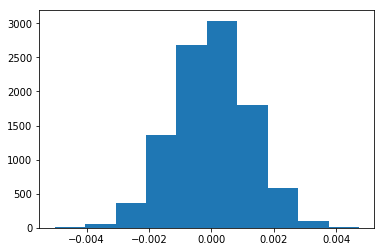

In [69]:

p_diffs = np.array(p_diffs)
plt.hist(p_diffs);


j. Proportion of  **p_diffs**  greater than the actual difference observed in **ab_data.csv**?

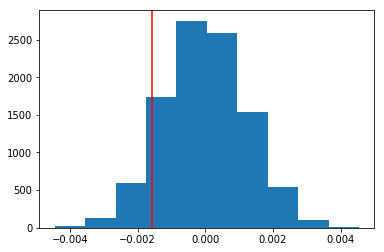

In [70]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# plot null distribution

plt.hist(null_vals)
# plot line for observed statistic
obs_stat = df_treat['converted'].mean() - df_ctrl['converted'].mean()
plt.axvline(x= obs_stat ,color ='red')

In [71]:
(null_vals > obs_stat).mean()

0.90439999999999998

**Analysis.**
in part J,  we simulated and plotted the distribution under the null hypothesis, the red line is the plot line for observed statistic. the red line falls in the middle of the shaded space, almost on the 0, it means that our observed statistics is within the null hypothesis. the results obtained come to confirm that, the P value is large and > 0.05 this means that we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [72]:
import statsmodels.api as sm

convert_old = df2_new.query('converted == 1')['user_id'].count()
convert_new = df2_old.query('converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
convert_old,n_old, n_new

(17264, 145274, 145310)

m. Use of `stats.proportions_ztest` to compute the test statistic and p-value.  

In [73]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='larger')

z_score, p_value

(-1.2616957421858055, 0.89647085519672265)

**Analysis.**
the p value is > 5% so we fail to reject the null hypothesis, in addition the Z score and this confirms the findings because it is less than the mean. This lead us to the conclusion that there is no significant difference between the 2 pages.   

<a id='regression'></a>
### Part III - A regression approach

`1.` Acheiving the A/B test results by performing Regression.<br><br>



I am going to use the logistic regression because we are predicting 2 possible outcomes: converted or didn't convert

In [74]:
# creation of a column for the intercept and a dummy variable, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('control', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,is_duplicated,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


c. Use **statsmodels** to import the regression model.  Instantiating and fitting the model using the columns created in order to predict whether or not an individual converts.

In [75]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model.

In [76]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:34:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**Analysis.**
the Pvalue is 0.190.
in the first part we are analyzing if one page induces more conversion than the other one, the p value is 0.90 and it represents a big chunk of the plot, for the regression we are interested in the effect that the variable can have, so the p value is in the 2 tails, (2*0.1)~0.19
the first part the hypothesis are inequalities and for regression tey are equalities.


Adding more variables into the regression model will give us more information about our dependant variable, and what other variables can influence it. and if there is any correlation between them.

adding the variable country to the regression model


In [77]:
df_c= pd.read_csv('countries.csv')
df_c.head()
df_full = pd.merge(df2,df_c, on='user_id', how='outer')
df_full[['US','UK','CA']] = pd.get_dummies(df_full['country'])

# create the logistic model and fit it 
logit_mod_full = sm.Logit(df_full['converted'], df_full[['intercept','US','UK']])
results = logit_mod_full.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 27 May 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:34:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [78]:
(1/np.exp(-0.0408)), np.exp(0.0099)
# the UK is likely to convert 1 time more than CA 
#the US is likely to convert 1.04 time less than CA
# the country doesn't have a big influence on the conversion and the P value can show that

(1.0416437559600236, 1.0099491671175422)

h. Interaction between page and country to see if there significant effects on conversion.  


In [79]:
logit_mod_final = sm.Logit(df_full['converted'], df_full[['intercept','ab_page','US','UK','CA']])
results_final = logit_mod_final.fit()
results_final.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        22:34:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4997   2.23e+05  -6.73e-06      1.000   -4.36e+05    4.36e+05
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.5304   2.23e+05  -2.38e-06      1.000   -4.36e+05    4.36e+05
UK            -0.4797   2.23e+05  -2.15e-06      1.000   -4.36e+05    4.36e+05
CA            -0.4896   2.23e+05   -2.2e-06      1.000   -4.36e+05    4.36e+05
==============================================================================
"""

In [80]:
(1/np.exp(-0.0149)),(1/np.exp(-0.5304)),(1/np.exp(-0.4797)),(1/np.exp(-0.4896))

# the country doesn't have any effect on the conversion rate 
# and the P value for the 3 countries is 1, so it confirms the conclusion
# the page  have little negative influence on the conversion, 

(1.0150115583846535, 1.6996120174747065, 1.615589652588312, 1.6316634240352847)

In [81]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0